In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

In [52]:
column_names = ['id', 'diagnosis']
for i in range(30):  
    column_names.append(f'feature_{i}')

df = pd.read_csv('data.csv', header=None, names=column_names)
df = df.drop('id', axis=1)
df.head()

,diagnosis,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,...,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [53]:
def encodage(df):
    dico = {
        'M' : 1,
        'B' : 0
    }
    df['diagnosis'] = df['diagnosis'].map(dico)
    return df


In [54]:
def preprocessing(df):
    X = df.drop('diagnosis', axis=1)
    y = df['diagnosis']
    labelencoder = LabelEncoder()
    standardscaler = StandardScaler()
    y = 1 - labelencoder.fit_transform(y)
    X_scaled = standardscaler.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
    return X_train, X_test, y_train, y_test

In [55]:
X_train, X_test, y_train, y_test = preprocessing(df)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from tqdm import tqdm
from sklearn.metrics import accuracy_score
class Multi_layer_perceptron:
    def __init__(self, X_train, y_train, X_test, y_test, hidden_layers=(32, 32, 32), learning_rate=0.01, num_iterations=10000):
        # Initialisation des paramètres
        self.X = X_train.T
        self.y = y_train.reshape(1, -1)
        self.X_test = X_test.T
        self.y_test = y_test.reshape(1, -1)
        self.X = self.X.reshape(self.X.shape[0], -1)
        self.X_test = self.X_test.reshape(self.X_test.shape[0], -1)    
        self.learning_rate = learning_rate
        self.num_iterations = num_iterations
        
        if isinstance(hidden_layers, int):
            dimensions = [hidden_layers]  # Convert single integer to list with one element
        else:
            dimensions = list(hidden_layers)
            
        dimensions.insert(0, self.X.shape[0])  
        dimensions.append(self.y.shape[0])    
        self.parametre = self.initialisation(dimensions)
        self.loss_train = []
        self.loss_test = []
        self.acc_train = []
        self.acc_test = []

    def initialisation(self, dimensions):
        parametre = {}
        C = len(dimensions)
        for c in range(1,C):
            parametre['W' + str(c)] = np.random.randn(dimensions[c], dimensions[c - 1])
            parametre['b' + str(c)] = np.random.randn(dimensions[c], 1)
        return parametre

    def forward_propagation(self, X=None):
        # Allow passing X as parameter or use self.X by default pour le graph X_test
        if X is None:
            X = self.X
        parametre = self.parametre
        C = len(self.parametre) // 2
        activations = {'A0': X}
        for c in range(1, C + 1):
            Z = parametre['W' + str(c)].dot(activations['A' + str(c - 1)]) + parametre['b' + str(c)]
            Z = np.clip(Z, -500, 500)
            activations['A' + str(c)] = 1 / (1 + np.exp(-Z))
        return activations

    def log_loss(self, A, y):
        # Calcul de la fonction de perte logistique
        m = y.shape[1]  
        A = np.clip(A, 1e-15, 1 - 1e-15)  # Prevent log(0)
        erreur = (-1 / m) * np.sum(y * np.log(A) + (1 - y) * np.log(1 - A))
        return erreur

    def back_propagation(self, activations): 
        # Calcul des gradients (dérivées)
        m = self.y.shape[1]
        C = len(self.parametre) // 2 
        parametre = self.parametre
        dZ = activations['A' + str(C)] - self.y
        gradients = {}
        for c in reversed(range(1, C + 1)):
            gradients['dW' + str(c)] = (1/m) * np.dot(dZ, activations['A' + str(c - 1)].T) 
            gradients['db' + str(c)] = (1/m) * np.sum(dZ, axis=1, keepdims=True)
            if c > 1:
                dZ = np.dot(parametre['W' + str(c)].T, dZ) * activations['A' + str(c - 1)] * (1 - activations['A' + str(c - 1)])  # Fix: use activations

        return gradients

    def update(self, gradient, learning_rate):
        C = len(self.parametre) // 2
        parametre = self.parametre
        for c in range(1, C + 1):
            parametre['W' + str(c)] = parametre['W' + str(c)] - learning_rate * gradient['dW' + str(c)]
            parametre['b' + str(c)] = parametre['b' + str(c)] - learning_rate * gradient['db' + str(c)]

        return parametre
    
    def predict(self, X=None):
        # Allow passing X as parameter or use self.X by default
        if X is None:
            X = self.X
            
        activation = self.forward_propagation(X)
        C = len(self.parametre) // 2 
        return activation['A' + str(C)] >= 0.5

    def cost_plot(self):
        # Tracer l'évolution de la fonction de coût
        plt.figure(figsize=(10, 6))
        plt.plot(self.loss_train, label='Train Loss')
        plt.plot(self.loss_test, label='Test Loss')
        plt.xlabel("Nombre itérations")
        plt.ylabel("Cost")
        plt.legend()
        plt.title("Evolution de la fonction de perte")
        plt.show()
    
    def acc_plot(self):
        # Tracer l'évolution de l'accuracy'
        plt.figure(figsize=(10, 6))
        plt.plot(self.acc_train, label='Train Accuracy')
        plt.plot(self.acc_test, label='Test Accuracy')
        plt.xlabel("Nombre itérations")
        plt.ylabel("Accuracy")
        plt.legend()
        plt.title("Evolution de l'accuracy")
        plt.show()

    def gradient_descent(self):
        # Descente de gradient pour l'entraînement du modèle
        for i in tqdm(range(self.num_iterations)):
            if i % 100 == 0:
                C = len(self.parametre) // 2
                # Train metrics
                activations_train = self.forward_propagation(self.X)
                self.loss_train.append(self.log_loss(activations_train['A' + str(C)], self.y))
                y_pred_train = self.predict(self.X)
                self.acc_train.append(accuracy_score(self.y.flatten(), y_pred_train.flatten()))
                
                # Test metrics
                activations_test = self.forward_propagation(self.X_test)
                self.loss_test.append(self.log_loss(activations_test['A' + str(C)], self.y_test))
                y_pred_test = self.predict(self.X_test)
                self.acc_test.append(accuracy_score(self.y_test.flatten(), y_pred_test.flatten()))
            
            # Training step
            activations = self.forward_propagation()
            gradients = self.back_propagation(activations) 
            self.update(gradients, self.learning_rate)
        
        # Display results
        self.cost_plot()
        self.acc_plot()
        y_pred = self.predict(self.X_test)
        print(classification_report(self.y_test.flatten(), y_pred.flatten())) 
        # return self.parametre

In [57]:
y_train.shape

(455,)

100%|██████████| 10000/10000 [00:53<00:00, 186.04it/s]


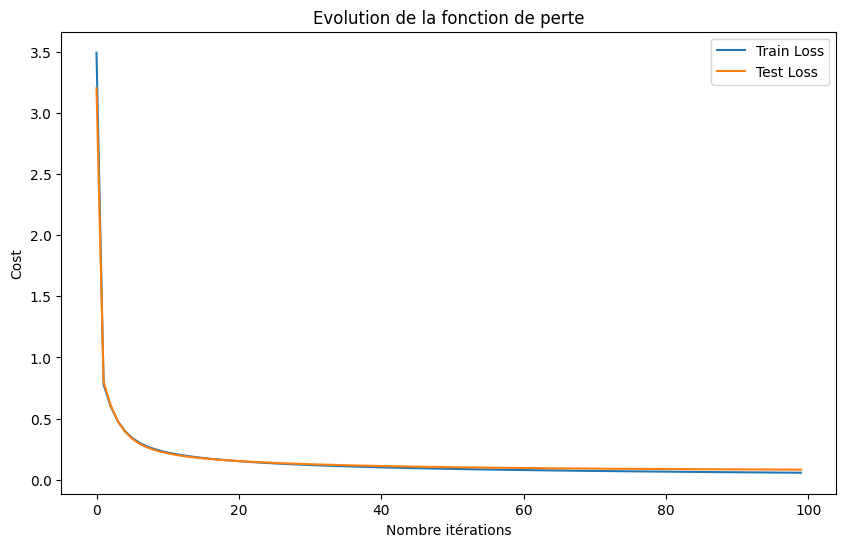

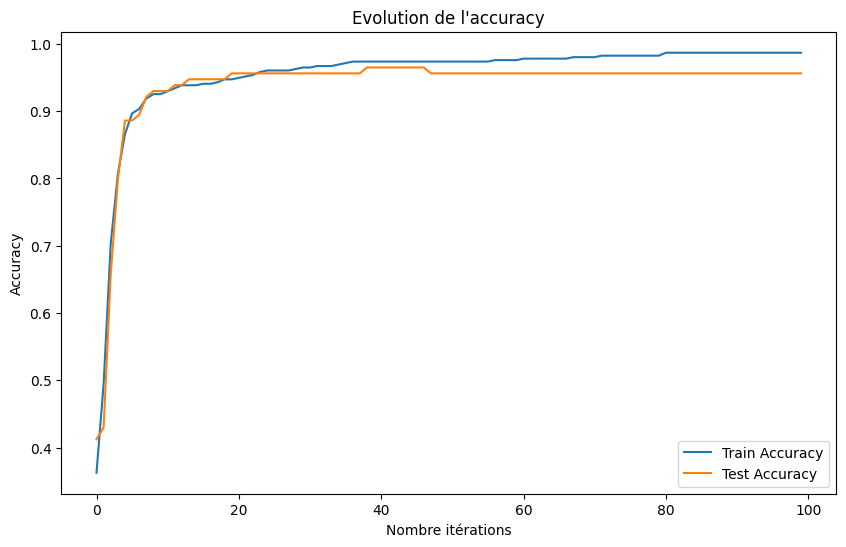

              precision    recall  f1-score   support

           0       0.94      0.96      0.95        47
           1       0.97      0.96      0.96        67

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114



{'W1': array([[-1.29586661e+00, -1.01244487e+00, -1.19679203e-01,
         -1.27567372e+00,  1.07379240e+00, -1.53681886e+00,
          1.25327852e+00, -1.20110969e+00, -6.74361721e-01,
          1.40258556e+00, -1.89244055e+00, -9.72023365e-01,
          1.39724277e-01, -8.00309387e-01, -8.92326361e-01,
         -6.26269550e-02,  4.71691534e-01,  2.11766370e-01,
          8.93535529e-01,  2.19730730e+00,  4.65891160e-01,
         -8.29787758e-02, -2.41157207e-01, -5.02216006e-01,
         -4.34300895e-01,  8.76030223e-02, -2.67289917e+00,
         -1.50245029e+00,  7.95955654e-01, -1.71520332e+00],
        [-3.18223681e-01,  1.09688974e+00, -2.05091497e-01,
          1.42535057e+00,  1.70572896e+00, -1.52517643e+00,
         -9.63661057e-01,  9.65647387e-01, -1.43729063e+00,
          1.40982870e-01,  4.55489485e-02, -6.99259244e-01,
          9.49675290e-01,  1.89330402e-01, -5.66211559e-01,
         -1.84662972e+00,  4.32968912e-01,  1.85473155e+00,
          7.18879340e-01, -2.0908

In [58]:
model = Multi_layer_perceptron(X_train, y_train,X_test, y_test)
model.gradient_descent()